In [1]:
#yahoo finance as data source
#pip install yfinance
import yfinance as yf

In [2]:
#See the yahoo finance ticker for your stock symbol
stock_symbol = 'MRF.NS'

In [3]:
#last 5 years data with interval of 1 day
data = yf.download(tickers=stock_symbol,period='5y',interval='1d')

[*********************100%%**********************]  1 of 1 completed


In [4]:
type(data)

pandas.core.frame.DataFrame

In [5]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-09-10,71501.0,71550.046875,70450.000000,70506.500000,70009.523438,4334
2018-09-11,70506.5,71099.953125,69600.000000,69769.546875,69277.781250,3404
2018-09-12,69860.0,69958.953125,68201.101562,69143.351562,68656.007812,8913
2018-09-14,69500.0,70712.898438,69500.000000,70244.296875,69749.187500,6967
2018-09-17,70200.0,70200.000000,69650.101562,69782.296875,69290.460938,2670


In [6]:
len(data)

1235

In [7]:
data.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-09-04,108499.000000,108980.000000,107347.546875,108195.398438,108195.398438,4965
2023-09-05,108453.703125,108800.000000,107888.148438,108520.000000,108520.000000,3494
2023-09-06,108250.500000,109537.953125,107500.000000,109395.750000,109395.750000,8365
2023-09-07,108831.000000,109885.601562,108798.796875,109205.148438,109205.148438,2632
2023-09-08,109300.000000,109420.750000,108600.203125,108858.398438,108858.398438,2651


In [8]:
opn = data[['Open']]

<Axes: xlabel='Date'>

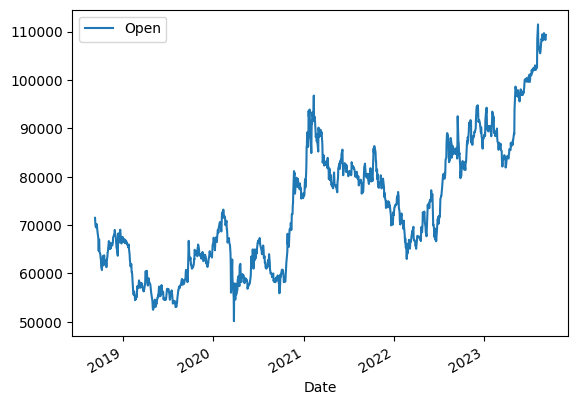

In [9]:
opn.plot()

In [10]:
import matplotlib.pyplot as plt

In [11]:
ds = opn.values

In [12]:
ds

array([[ 71501. ],
       [ 70506.5],
       [ 69860. ],
       ...,
       [108250.5],
       [108831. ],
       [109300. ]])

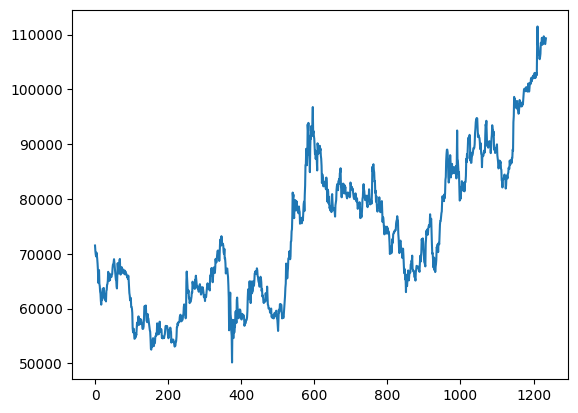

In [13]:
plt.plot(ds)

In [14]:
import numpy as np

In [15]:
from sklearn.preprocessing import MinMaxScaler

In [16]:
#Using MinMaxScaler for normalizing data between 0 & 1
normalizer = MinMaxScaler(feature_range=(0,1))
ds_scaled = normalizer.fit_transform(np.array(ds).reshape(-1,1))

In [17]:
len(ds_scaled), len(ds)

(1235, 1235)

In [18]:
#Defining test and train data sizes
train_size = int(len(ds_scaled)*0.70)
test_size = len(ds_scaled) - train_size

In [19]:
train_size,test_size

(864, 371)

In [20]:
#Splitting data between train and test
ds_train, ds_test = ds_scaled[0:train_size,:], ds_scaled[train_size:len(ds_scaled),:1]

In [21]:
len(ds_train),len(ds_test)

(864, 371)

In [22]:
#creating dataset in time series for LSTM model 
#X[100,120,140,160,180] : Y[200]
def create_ds(dataset,step):
    Xtrain, Ytrain = [], []
    for i in range(len(dataset)-step-1):
        a = dataset[i:(i+step), 0]
        Xtrain.append(a)
        Ytrain.append(dataset[i + step, 0])
    return np.array(Xtrain), np.array(Ytrain)

In [23]:
#Taking 100 days price as one record for training
time_stamp = 100
X_train, y_train = create_ds(ds_train,time_stamp)
X_test, y_test = create_ds(ds_test,time_stamp)

In [24]:
X_train.shape,y_train.shape

((763, 100), (763,))

In [25]:
X_test.shape, y_test.shape

((270, 100), (270,))

In [26]:
#Reshaping data to fit into LSTM model
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [27]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [28]:
#Creating LSTM model using keras
model = Sequential()
model.add(LSTM(units=50,return_sequences=True,input_shape=(X_train.shape[1],1)))
model.add(LSTM(units=50,return_sequences=True))
model.add(LSTM(units=50))
model.add(Dense(units=1,activation='linear'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50851 (198.64 KB)
Trainable params: 50851 (198.64 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [29]:
#Training model with adam optimizer and mean squared error loss function
model.compile(loss='mean_squared_error',optimizer='adam')
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100,batch_size=64)

Epoch 1/100
12/12 [==============================] - 13s 414ms/step - loss: 0.0285 - val_loss: 0.0459
Epoch 2/100
12/12 [==============================] - 3s 293ms/step - loss: 0.0077 - val_loss: 0.0045
Epoch 3/100
12/12 [==============================] - 3s 294ms/step - loss: 0.0047 - val_loss: 0.0094
Epoch 4/100
12/12 [==============================] - 4s 325ms/step - loss: 0.0031 - val_loss: 0.0079
Epoch 5/100
12/12 [==============================] - 4s 326ms/step - loss: 0.0030 - val_loss: 0.0033
Epoch 6/100
12/12 [==============================] - 3s 258ms/step - loss: 0.0026 - val_loss: 0.0035
Epoch 7/100
12/12 [==============================] - 3s 244ms/step - loss: 0.0025 - val_loss: 0.0035
Epoch 8/100
12/12 [==============================] - 38s 3s/step - loss: 0.0024 - val_loss: 0.0025
Epoch 9/100
12/12 [==============================] - 5s 413ms/step - loss: 0.0024 - val_loss: 0.0023
Epoch 10/100
12/12 [==============================] - 4s 308ms/step - loss: 0.0022 - val_los

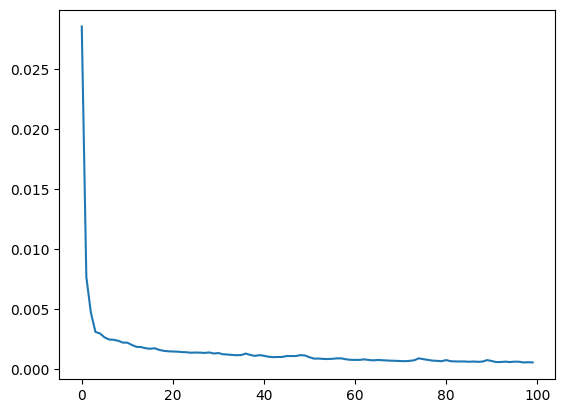

In [30]:
#PLotting loss, it shows that loss has decreased significantly and model trained well
loss = model.history.history['loss']
plt.plot(loss)

In [31]:
#Predicitng on train and test data
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

9/9 [==============================] - 0s 47ms/step


In [32]:
#Inverse transform to get actual value
train_predict = normalizer.inverse_transform(train_predict)
test_predict = normalizer.inverse_transform(test_predict)

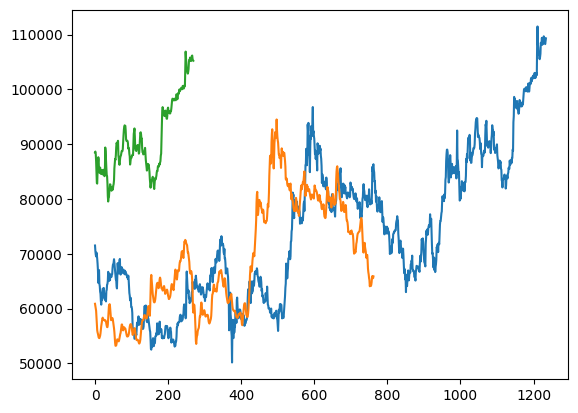

In [33]:
#Comparing using visuals
plt.plot(normalizer.inverse_transform(ds_scaled))
plt.plot(train_predict)
plt.plot(test_predict)

In [34]:
type(train_predict)

numpy.ndarray

In [35]:
test = np.vstack((train_predict,test_predict))

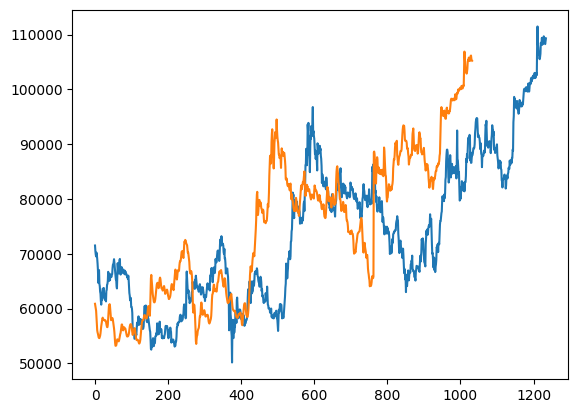

In [36]:
#Combining the predited data to create uniform data visualization
plt.plot(normalizer.inverse_transform(ds_scaled))
plt.plot(test)

In [37]:
len(ds_test)

371

In [38]:
#Getting the last 100 days records
fut_inp = ds_test[270:]

In [39]:
fut_inp = fut_inp.reshape(1,-1)

In [40]:
tmp_inp = list(fut_inp)

In [41]:
fut_inp.shape

(1, 101)

In [42]:
#Creating list of the last 100 data
tmp_inp = tmp_inp[0].tolist()

In [43]:
#Predicting next 30 days price suing the current data
#It will predict in sliding window manner (algorithm) with stride 1
lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(tmp_inp)>100):
        fut_inp = np.array(tmp_inp[1:])
        fut_inp=fut_inp.reshape(1,-1)
        fut_inp = fut_inp.reshape((1, n_steps, 1))
        yhat = model.predict(fut_inp, verbose=0)
        tmp_inp.extend(yhat[0].tolist())
        tmp_inp = tmp_inp[1:]
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        fut_inp = fut_inp.reshape((1, n_steps,1))
        yhat = model.predict(fut_inp, verbose=0)
        tmp_inp.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[[0.9104926586151123], [0.8813877701759338], [0.852471113204956], [0.8294428586959839], [0.8113217353820801], [0.7972539663314819], [0.7862387895584106], [0.7771897912025452], [0.7691574096679688], [0.7614316940307617], [0.7535587549209595], [0.7453135848045349], [0.7366476058959961], [0.7276291251182556], [0.7183912396430969], [0.7090851664543152], [0.6998535394668579], [0.6908103227615356], [0.6820361614227295], [0.6735770106315613], [0.6654496192932129], [0.6576483845710754], [0.650153398513794], [0.6429363489151001], [0.6359670162200928], [0.6292154788970947], [0.6226564049720764], [0.6162683963775635], [0.610035240650177], [0.6039448380470276]]


In [44]:
len(ds_scaled)

1235

In [45]:
#Creating a dummy plane to plot graph one after another
plot_new=np.arange(1,101)
plot_pred=np.arange(101,131)

In [47]:
ds_new = ds_scaled.tolist()

In [48]:
len(ds_new)

1235

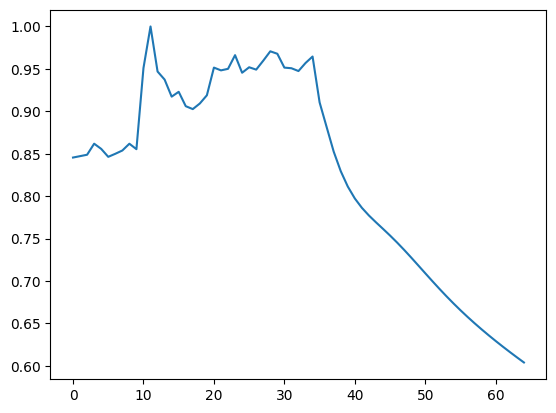

In [49]:
#Entends helps us to fill the missing value with approx value
ds_new.extend(lst_output)
plt.plot(ds_new[1200:])

In [50]:
#Creating final data for plotting
final_graph = normalizer.inverse_transform(ds_new).tolist()

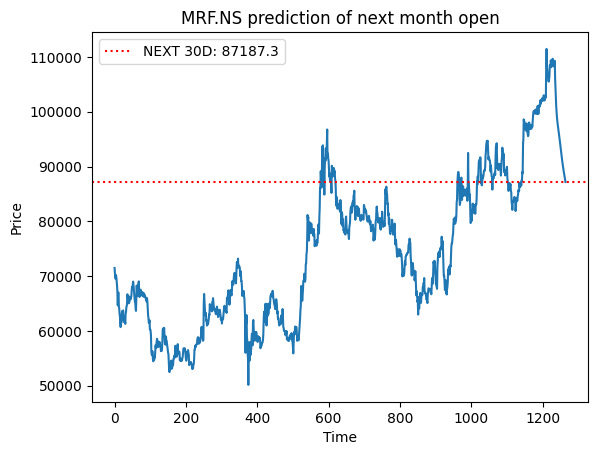

In [51]:
#Plotting final results with predicted value after 30 Days
plt.plot(final_graph,)
plt.ylabel("Price")
plt.xlabel("Time")
plt.title("{0} prediction of next month open".format(stock_symbol))
plt.axhline(y=final_graph[len(final_graph)-1], color = 'red', linestyle = ':', label = 'NEXT 30D: {0}'.format(round(float(*final_graph[len(final_graph)-1]),2)))
plt.legend()

